In [ ]:
!pip install -q -U "tensorflow-text==2.8.*"

     |████████████████████████████████| 4.9 MB 5.1 MB/s 
     |████████████████████████████████| 498.0 MB 8.9 kB/s 
     |████████████████████████████████| 1.4 MB 57.3 MB/s 
     |████████████████████████████████| 5.8 MB 40.4 MB/s 
     |████████████████████████████████| 462 kB 62.0 MB/s 


In [ ]:
!pip install -q tf-models-official==2.7.0

     |████████████████████████████████| 1.8 MB 4.9 MB/s 
     |████████████████████████████████| 118 kB 48.8 MB/s 
     |████████████████████████████████| 1.3 MB 43.7 MB/s 
     |████████████████████████████████| 352 kB 45.7 MB/s 
     |████████████████████████████████| 43 kB 825 kB/s 
     |████████████████████████████████| 238 kB 48.3 MB/s 
     |████████████████████████████████| 1.1 MB 12.2 MB/s 


In [ ]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optmizer

import matplotlib.pyplot as plt
import numpy as np

tf.get_logger().setLevel('ERROR')

In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

In [ ]:
import pandas as pd

data = pd.read_csv("training.1600000.processed.noemoticon.csv",encoding='latin-1',header=None)

In [ ]:
data.head()

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [ ]:
data.columns = ['target', 'id', 'date', 'flag','user','text']

In [ ]:
data.head()


,target,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [ ]:
#dropping unwanted columns
data = data.drop (['id','date','flag','user'],axis=1)

In [ ]:
data.head()

,target,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [ ]:
data.target.unique()

array([0, 4])

In [ ]:
data_positive = data[data['target'] == 4]
data_negative = data[data['target'] == 0]

In [ ]:
data_positive.count()

target    800000
text      800000
dtype: int64

In [ ]:
data_negative.count()

target    800000
text      800000
dtype: int64

In [ ]:
data['target'] = data['target'].replace([4], 1)


In [ ]:
data.target.unique()

array([0, 1])

In [ ]:
data_positive = data[data['target'] == 1]
data_negative = data[data['target'] == 0]

In [ ]:
data_positive = data_positive.iloc[:40000]
data_negative = data_negative.iloc[:40000]

In [ ]:
data = pd.concat([data_positive,data_negative])

In [ ]:
data.count()

target    80000
text      80000
dtype: int64

In [ ]:
from sklearn.utils import shuffle
data = shuffle(data)

In [ ]:
data.head()

,target,text
28832,0,@purdysmum i dont think @alancarr forgives me ...
837842,1,fabulous walk for MS. Beautiful day! Enjoying ...
836843,1,@robangus got to be original with judy garland...
27354,0,@JoelMadden watched it with my dog HUGE mistak...
811018,1,@TheDrJack don't worry! I got them back and m...


In [ ]:
data['text']

28832     @purdysmum i dont think @alancarr forgives me ...
837842    fabulous walk for MS. Beautiful day! Enjoying ...
836843    @robangus got to be original with judy garland...
27354     @JoelMadden watched it with my dog HUGE mistak...
811018    @TheDrJack don't worry! I got them back  and m...
                                ...                        
35362     @flyingmachine13 awww boo to that tweet  cut o...
38084     @writefast  no lol I got over my fears but I s...
826922    I shall attempt this 'sleep' thing at a decent...
836789    @billbeckett hey!!im ange from indonesia!i lov...
27399     Used the handicap stall. Walked out. Guy in a ...
Name: text, Length: 80000, dtype: object

In [ ]:
import nltk
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('omw-1.4')
from nltk.stem import WordNetLemmatizer 

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
from pandas.core.reshape.merge import string
import re


In [ ]:
def clean_string(text):

    

    text = str(text)

    # Make lower
    text = text.lower()

    clean_text = re.sub("@[A-Za-z0-9_]+","", text )

    clean_text = re.sub("#[A-Za-z0-9_]+","", clean_text)

    clean_text = re.sub('http[s]?://\S+', '', clean_text)

    # Remove line breaks
    clean_text = re.sub(r'\n', '', clean_text)

    clean_text = re.sub('<.*?>+', '', clean_text)

    clean_text = re.sub(r'(!|.)1+', '', clean_text)

    # Remove puncuation
    translator = str.maketrans('', '', string.punctuation)
    clean_text = clean_text.translate(translator)
    clean_text = re.sub('\d+', '', clean_text)

    # Remove stop words
    #clean_text = clean_text.split()
    #stop_words = nltk.corpus.stopwords.words("english")
    #stopwords_dict = Counter(stop_words)
    #clean_text = [word for word in clean_text if not word in stopwords_dict]

    # Remove numbers
    #stemming
    lemmatizer = WordNetLemmatizer()

    clean_text = ' '.join(lemmatizer.lemmatize(word) for word in clean_text.split())
    

    clean_text = " ".join(clean_text.split())

    return clean_text


In [ ]:
data['clean_text'] = data['text'].apply(lambda x: clean_string(x))

In [ ]:
data.head(10)

,target,text,clean_text
28832,0,@purdysmum i dont think @alancarr forgives me ...,i dont think forgives me hunni lol
837842,1,fabulous walk for MS. Beautiful day! Enjoying ...,fabulous walk for m beautiful day enjoying the...
836843,1,@robangus got to be original with judy garland...,got to be original with judy garlandbut not se...
27354,0,@JoelMadden watched it with my dog HUGE mistak...,watched it with my dog huge mistakesuch a sad ...
811018,1,@TheDrJack don't worry! I got them back and m...,dont worry i got them back and more besides ac...
824543,1,@DawnRichard well u have the drive and determi...,well u have the drive and determination so i k...
827572,1,today i found the perfect place to do an outdo...,today i found the perfect place to do an outdo...
24830,0,is taking Alix Eve to LGA for her flight to CM...,is taking alix eve to lga for her flight to cm...
820540,1,Work. Then nap,work then nap
9663,0,"@benjorg Benny, when is AFS gonna start tourin...",benny when is afs gonna start touring again i ...


In [ ]:
data = data.drop(['text'],axis=1)

In [ ]:
data.count()

target        80000
clean_text    80000
dtype: int64

Splitting train and test data

In [ ]:
from sklearn.model_selection import train_test_split


In [ ]:
(train_x, test_x, train_y, test_y) = train_test_split(data["clean_text"], data["target"],random_state=22)

In [ ]:
train_x.count()

60000

In [ ]:
#creating validation dataset from train data with a split of 0.8 and 0.2
(train_x, val_x, train_y, val_y) = train_test_split(train_x, train_y,train_size=0.8,random_state=22)

In [ ]:
train_x.count()

48000

In [ ]:
train_x.head()

805151    with parentals and relative in hkg yes with si...
38154     there not going to be a rd season of fotc supe...
25624        so tired i dont like go back to my normal life
22520     you all failed thanks i might go and spend mor...
821476                                 watching scary movie
Name: clean_text, dtype: object

In [ ]:
test_y.count()

20000

In [ ]:
test_y.head()

8867      0
25615     0
15954     0
5990      0
833723    1
Name: target, dtype: int64

In [ ]:
val_x.count()

12000

In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices((train_x, train_y)) 
train_ds= train_ds.batch(32)

In [ ]:
test_ds = tf.data.Dataset.from_tensor_slices((test_x, test_y)) 
test_ds = test_ds.batch(32)

In [ ]:
validation_ds = tf.data.Dataset.from_tensor_slices((val_x, val_y)) 
validation_ds = validation_ds.batch(32)

In [ ]:
for example, label in train_ds.take(1):
  print('clean_text: ', example.numpy()[:3])
  print()
  print('target: ', label.numpy()[:3])

clean_text:  [b'with parentals and relative in hkg yes with sibling no cant read or write chinese though'
 b'there not going to be a rd season of fotc super bummed'
 b'so tired i dont like go back to my normal life']

target:  [1 0 0]


In [ ]:
VOCAB_SIZE=1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_ds.map(lambda text, label: text))

In [ ]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'i', 'to', 'the', 'a', 'it', 'and', 'my', 'you', 'is',
       'in', 'for', 'of', 'on', 'im', 'me', 'have', 'so', 'that'],
      dtype='<U13')

In [ ]:
print(example[:3])
encoded_example = encoder(example[:3]).numpy()
encoded_example

tf.Tensor(
[b'with parentals and relative in hkg yes with sibling no cant read or write chinese though'
 b'there not going to be a rd season of fotc super bummed'
 b'so tired i dont like go back to my normal life'], shape=(3,), dtype=string)


array([[ 24,   1,   7,   1,  11,   1, 152,  24,   1,  40,  48, 299, 109,
        513,   1, 127],
       [ 68,  25,  42,   3,  23,   5,   1, 561,  13,   1, 533, 997,   0,
          0,   0,   0],
       [ 18, 176,   2,  47,  39,  34,  43,   3,   8,   1, 174,   0,   0,
          0,   0,   0]])

In [ ]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))

Original:  b'with parentals and relative in hkg yes with sibling no cant read or write chinese though'
Round-trip:  with [UNK] and [UNK] in [UNK] yes with [UNK] no cant read or write [UNK] though
Original:  b'there not going to be a rd season of fotc super bummed'
Round-trip:  there not going to be a [UNK] season of [UNK] super bummed    
Original:  b'so tired i dont like go back to my normal life'
Round-trip:  so tired i dont like go back to my [UNK] life     


In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, min_delta=1e-3, restore_best_weights=True)

In [ ]:
history = model.fit(train_ds, epochs=10,
                    validation_data=validation_ds, 
                    validation_steps=30,
                    callbacks=early_stopping)

Epoch 1/10
1500/1500 [==============================] - 82s 49ms/step - loss: 0.5777 - accuracy: 0.7104 - val_loss: 0.5196 - val_accuracy: 0.7552
Epoch 2/10
1500/1500 [==============================] - 74s 49ms/step - loss: 0.4884 - accuracy: 0.7689 - val_loss: 0.5049 - val_accuracy: 0.7563
Epoch 3/10
1500/1500 [==============================] - 70s 47ms/step - loss: 0.4775 - accuracy: 0.7725 - val_loss: 0.5023 - val_accuracy: 0.7521
Epoch 4/10
1500/1500 [==============================] - 69s 46ms/step - loss: 0.4732 - accuracy: 0.7745 - val_loss: 0.5008 - val_accuracy: 0.7531
Epoch 5/10
1500/1500 [==============================] - 67s 45ms/step - loss: 0.4698 - accuracy: 0.7765 - val_loss: 0.4991 - val_accuracy: 0.7573
Epoch 6/10
1500/1500 [==============================] - 68s 45ms/step - loss: 0.4662 - accuracy: 0.7774 - val_loss: 0.4972 - val_accuracy: 0.7615
Epoch 7/10
1500/1500 [==============================] - 67s 45ms/step - loss: 0.4620 - accuracy: 0.7785 - val_loss: 0.4952 -

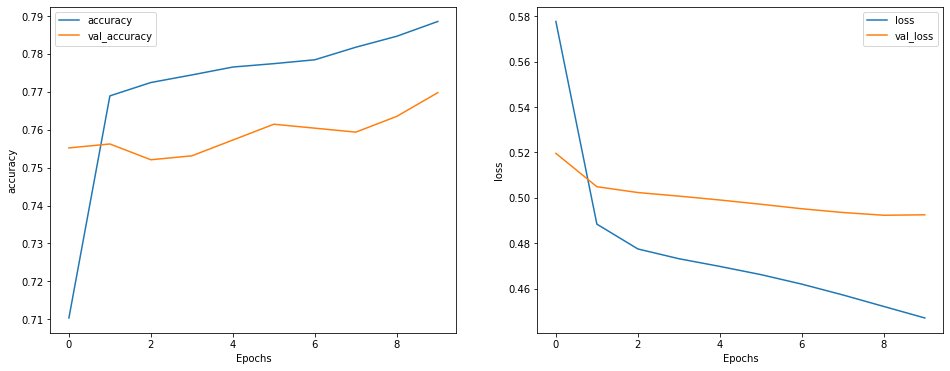

In [ ]:
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plot_graphs(history, 'accuracy')
plt.subplot(1,2,2)
plot_graphs(history, 'loss')

Adding more LSTM layers

In [ ]:
model1 = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

In [ ]:
model1.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, min_delta=1e-3, restore_best_weights=True)

In [ ]:
history = model1.fit(train_ds, epochs=10,
                    validation_data=validation_ds, 
                    validation_steps=30,
                    callbacks=early_stopping)

Epoch 1/10
1500/1500 [==============================] - 153s 92ms/step - loss: 0.5817 - accuracy: 0.7078 - val_loss: 0.5283 - val_accuracy: 0.7437
Epoch 2/10
1500/1500 [==============================] - 136s 90ms/step - loss: 0.4958 - accuracy: 0.7697 - val_loss: 0.5138 - val_accuracy: 0.7510
Epoch 3/10
1500/1500 [==============================] - 132s 88ms/step - loss: 0.4839 - accuracy: 0.7744 - val_loss: 0.5070 - val_accuracy: 0.7542
Epoch 4/10
1500/1500 [==============================] - 131s 87ms/step - loss: 0.4780 - accuracy: 0.7768 - val_loss: 0.5028 - val_accuracy: 0.7615
Epoch 5/10
1500/1500 [==============================] - 130s 87ms/step - loss: 0.4737 - accuracy: 0.7784 - val_loss: 0.5002 - val_accuracy: 0.7604
Epoch 6/10
1500/1500 [==============================] - 127s 85ms/step - loss: 0.4692 - accuracy: 0.7801 - val_loss: 0.4967 - val_accuracy: 0.7573
Epoch 7/10
1500/1500 [==============================] - 137s 91ms/step - loss: 0.4668 - accuracy: 0.7821 - val_loss: 0

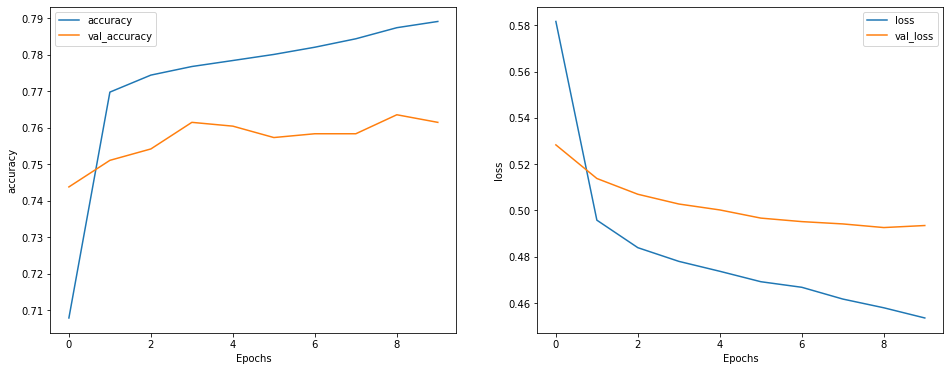

In [ ]:
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plot_graphs(history, 'accuracy')
plt.subplot(1,2,2)
plot_graphs(history, 'loss')

In [ ]:
data.count()

target        80000
clean_text    80000
dtype: int64

In [ ]:
data_positive = data[data['target'] == 1]
data_negative = data[data['target'] == 0]

Selecting only 30000 rows 

In [ ]:
data_positive = data_positive.iloc[:15000]
data_negative = data_negative.iloc[:15000]

In [ ]:
data1 = pd.concat([data_positive,data_negative])

In [ ]:
from sklearn.utils import shuffle
data1 = shuffle(data1)

In [ ]:
data1.count()

target        30000
clean_text    30000
dtype: int64

In [ ]:
data1.head()

,target,clean_text
12744,0,of course when i go outside the sun go away
835860,1,np just keep the great content coming
828969,1,iphone o now installed this copy and paste thi...
802394,1,long day hope i can catch a few zzs a a result...
836865,1,watching guitar hero vids on youtube


In [ ]:
(train1_x, test1_x, train1_y, test1_y) = train_test_split(data1["clean_text"], data1["target"],random_state=22)

In [ ]:
#creating validation dataset from train data with a split of 0.8 and 0.2
(train1_x, val1_x, train1_y, val1_y) = train_test_split(train1_x, train1_y,train_size=0.8,random_state=22)

Selecting only 18k rows of data to train BERT model

In [ ]:
train1_x.count()

18000

In [ ]:
train1_ds = tf.data.Dataset.from_tensor_slices((train1_x, train1_y)) 
train1_ds= train1_ds.batch(32)

In [ ]:
test1_ds = tf.data.Dataset.from_tensor_slices((test1_x, test1_y)) 
test1_ds= test1_ds.batch(32)

In [ ]:
                               
validation1_ds= tf.data.Dataset.from_tensor_slices((val1_x, val1_y)) 
validation1_ds= validation1_ds.batch(32)

In [ ]:
#@title Choose a BERT model to fine-tune

bert_model_name = 'small_bert/bert_en_uncased_L-2_H-256_A-4'  #@param ["bert_en_uncased_L-12_H-768_A-12", "bert_en_cased_L-12_H-768_A-12", "bert_multi_cased_L-12_H-768_A-12", "small_bert/bert_en_uncased_L-2_H-128_A-2", "small_bert/bert_en_uncased_L-2_H-256_A-4", "small_bert/bert_en_uncased_L-2_H-512_A-8", "small_bert/bert_en_uncased_L-2_H-768_A-12", "small_bert/bert_en_uncased_L-4_H-128_A-2", "small_bert/bert_en_uncased_L-4_H-256_A-4", "small_bert/bert_en_uncased_L-4_H-512_A-8", "small_bert/bert_en_uncased_L-4_H-768_A-12", "small_bert/bert_en_uncased_L-6_H-128_A-2", "small_bert/bert_en_uncased_L-6_H-256_A-4", "small_bert/bert_en_uncased_L-6_H-512_A-8", "small_bert/bert_en_uncased_L-6_H-768_A-12", "small_bert/bert_en_uncased_L-8_H-128_A-2", "small_bert/bert_en_uncased_L-8_H-256_A-4", "small_bert/bert_en_uncased_L-8_H-512_A-8", "small_bert/bert_en_uncased_L-8_H-768_A-12", "small_bert/bert_en_uncased_L-10_H-128_A-2", "small_bert/bert_en_uncased_L-10_H-256_A-4", "small_bert/bert_en_uncased_L-10_H-512_A-8", "small_bert/bert_en_uncased_L-10_H-768_A-12", "small_bert/bert_en_uncased_L-12_H-128_A-2", "small_bert/bert_en_uncased_L-12_H-256_A-4", "small_bert/bert_en_uncased_L-12_H-512_A-8", "small_bert/bert_en_uncased_L-12_H-768_A-12", "albert_en_base", "electra_small", "electra_base", "experts_pubmed", "experts_wiki_books", "talking-heads_base"]

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [ ]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [ ]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [ ]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')(text_input)
  Bert_layer = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')(preprocessing_layer)
  Bert_output = Bert_layer['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(Bert_output)
  output_layer = tf.keras.layers.Dense(1, activation="sigmoid", name='classifier')(net)
  return tf.keras.Model(text_input, output_layer)

In [ ]:
classifier_model = build_classifier_model()

In [ ]:
epochs = 5
steps_per_epoch = tf.data.experimental.cardinality(train1_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 5e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [ ]:
classifier_model.compile(optimizer=optimizer,
                         loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                         metrics='accuracy')

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, min_delta=1e-3, restore_best_weights=True)

In [ ]:

print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train1_ds,
                               validation_data=validation1_ds,
                               epochs=epochs,
                               callbacks=early_stopping)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1
Epoch 1/5
563/563 [==============================] - 882s 2s/step - loss: 0.6256 - accuracy: 0.6460 - val_loss: 0.5045 - val_accuracy: 0.7593
Epoch 2/5
563/563 [==============================] - 869s 2s/step - loss: 0.4865 - accuracy: 0.7643 - val_loss: 0.4812 - val_accuracy: 0.7729
Epoch 3/5
563/563 [==============================] - 872s 2s/step - loss: 0.4424 - accuracy: 0.7972 - val_loss: 0.4823 - val_accuracy: 0.7780
Epoch 4/5
563/563 [==============================] - 876s 2s/step - loss: 0.4110 - accuracy: 0.8166 - val_loss: 0.4829 - val_accuracy: 0.7789
Epoch 5/5
563/563 [==============================] - 874s 2s/step - loss: 0.3893 - accuracy: 0.8277 - val_loss: 0.4844 - val_accuracy: 0.7802


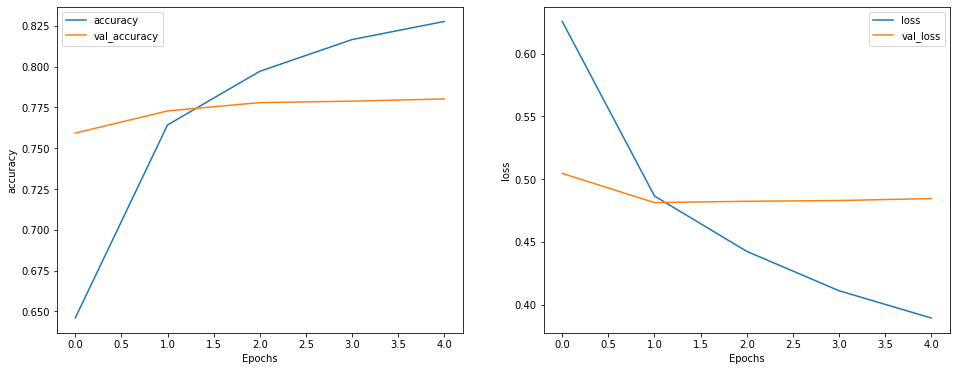

In [ ]:
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plot_graphs(history, 'accuracy')
plt.subplot(1,2,2)
plot_graphs(history, 'loss')

Evaluation of baseline model on test data

In [ ]:
predictions = model.predict(val_x)
predictions = np.where(predictions>0.5,1,0)


In [ ]:
from sklearn.metrics import confusion_matrix
cf_matrix= confusion_matrix(val_y, predictions)
print(cf_matrix)

[[4466 1487]
 [1344 4703]]


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(val_y, predictions))

              precision    recall  f1-score   support

           0       0.77      0.75      0.76      5953
           1       0.76      0.78      0.77      6047

    accuracy                           0.76     12000
   macro avg       0.76      0.76      0.76     12000
weighted avg       0.76      0.76      0.76     12000



Evaluation of BERT model on validation data

In [ ]:
predictions1 = classifier_model.predict(val_x)
predictions1 = np.where(predictions1>0.5,1,0)

In [ ]:
from sklearn.metrics import confusion_matrix
cf_matrix= confusion_matrix(val_y, predictions1)
print(cf_matrix)

[[4823 1130]
 [1344 4703]]


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(val_y, predictions1))

              precision    recall  f1-score   support

           0       0.78      0.81      0.80      5953
           1       0.81      0.78      0.79      6047

    accuracy                           0.79     12000
   macro avg       0.79      0.79      0.79     12000
weighted avg       0.79      0.79      0.79     12000



Evaluation of best model on test data

In [ ]:
test_predictions = classifier_model.predict(test_x)
test_predictions = np.where(test_predictions>0.5,1,0)


In [ ]:
cf_matrix2= confusion_matrix(test_y, test_predictions)
print(cf_matrix2)

[[8129 1821]
 [2200 7850]]


In [ ]:
print(classification_report(test_y, test_predictions))

              precision    recall  f1-score   support

           0       0.79      0.82      0.80      9950
           1       0.81      0.78      0.80     10050

    accuracy                           0.80     20000
   macro avg       0.80      0.80      0.80     20000
weighted avg       0.80      0.80      0.80     20000

